# Drug dataset - Sentiment Analysis 

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay, plot_roc_curve
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/sabeiro/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sabeiro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/sabeiro/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package tagsets to /home/sabeiro/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sabeiro/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', index_col=[0])
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', index_col=[0])

## Preliminary data exploration

In [4]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [134]:
# Merge train and test sets

In [5]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [6]:
df

,drugName,condition,review,rating,date,usefulCount,length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,17
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
...,...,...,...,...,...,...,...
215058,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43,97
215059,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11,130
215060,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7,149
215061,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20,34


### Removal of duplicates!

In [7]:
df = df.drop_duplicates(subset=["condition" ,"review", "rating"]).reset_index(drop=True)

In [8]:
df.drugName.value_counts()

Levonorgestrel                       2533
Etonogestrel                         2245
Ethinyl estradiol / norethindrone    1945
Phentermine                          1813
Ethinyl estradiol / norgestimate     1519
                                     ... 
Molindone                               1
Primlev                                 1
Abacavir / lamivudine                   1
Asendin                                 1
Tagamet                                 1
Name: drugName, Length: 3199, dtype: int64

In [9]:
df.condition.value_counts()

Birth Control                                   19524
Depression                                       7113
Pain                                             5193
Anxiety                                          5091
Acne                                             4551
                                                ...  
135</span> users found this comment helpful.        1
64</span> users found this comment helpful.         1
Short Stature for Age                               1
Gonadotropin Inhibition                             1
Hypodermoclysis                                     1
Name: condition, Length: 916, dtype: int64

In [10]:
# No duplication
df.describe()

,rating,usefulCount,length
count,130285.000000,130285.000000,130285.000000
mean,6.997582,26.924059,84.258242
std,3.274199,35.135337,44.962225
min,1.000000,0.000000,1.000000
25%,5.000000,6.000000,48.000000
50%,8.000000,15.000000,84.000000
75%,10.000000,35.000000,126.000000
max,10.000000,1291.000000,1894.000000


In [11]:
df

,drugName,condition,review,rating,date,usefulCount,length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,17
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
...,...,...,...,...,...,...,...
130280,Methadone,Pain,"""Have been taking it for 6 years (120 milligra...",10.0,"August 2, 2011",16,12
130281,Clomipramine,Panic Disorde,"""I&#039;ve been on clomipramine 15 years now a...",10.0,"February 19, 2013",28,49
130282,Levetiracetam,Epilepsy,"""I now suffer from excessive tiredness and lac...",8.0,"July 21, 2016",5,20
130283,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43,97


In [12]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130285 entries, 0 to 130284
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     130285 non-null  object
 1   condition    129091 non-null  object
 2   review       130285 non-null  object
 3   rating       130285 non-null  int64 
 4   date         130285 non-null  object
 5   usefulCount  130285 non-null  int64 
 6   length       130285 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.0+ MB


In [14]:
df.isnull().any()

drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [15]:
sum(df.condition.isnull())

1194

### 'Rating' column

<AxesSubplot:xlabel='rating', ylabel='count'>

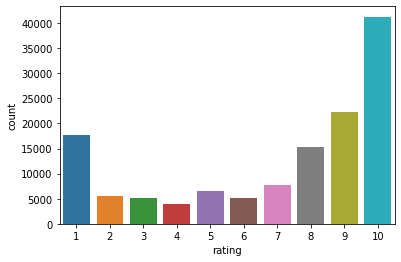

In [16]:
sns.countplot(df['rating'])

In [147]:
# data is skewed, imalanced towards positive ratings

In [17]:
df.rating.value_counts(normalize=True)

10    0.316744
9     0.170595
1     0.135303
8     0.117182
7     0.058902
5     0.049729
2     0.042146
3     0.039567
6     0.039375
4     0.030456
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

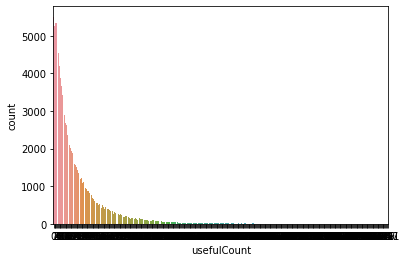

In [18]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

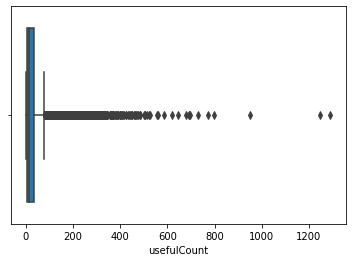

In [19]:
sns.boxplot(x=df['usefulCount'])

In [20]:
df['usefulCount'].describe()

count    130285.000000
mean         26.924059
std          35.135337
min           0.000000
25%           6.000000
50%          15.000000
75%          35.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [21]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

5510

In [22]:
df.usefulCount.value_counts()

0      5510
3      5340
2      5332
1      5251
4      5156
       ... 
332       1
359       1
295       1
333       1
319       1
Name: usefulCount, Length: 397, dtype: int64

In [23]:
df

,drugName,condition,review,rating,date,usefulCount,length
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,17
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,141
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,134
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,89
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,124
...,...,...,...,...,...,...,...
130280,Methadone,Pain,"""Have been taking it for 6 years (120 milligra...",10,"August 2, 2011",16,12
130281,Clomipramine,Panic Disorde,"""I&#039;ve been on clomipramine 15 years now a...",10,"February 19, 2013",28,49
130282,Levetiracetam,Epilepsy,"""I now suffer from excessive tiredness and lac...",8,"July 21, 2016",5,20
130283,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,"September 13, 2014",43,97


In [155]:
# Positive reviews found more useful (based on tableau graph)

In [156]:
#uc = df.usefulCount.value_counts().reset_index().rename(columns={"index": "values_c"}) 

In [157]:
#top5l = list(uc.sort_values(by="values_c",  ascending=False).reset_index(drop=True).iloc[0:5].values_c.values)

In [158]:
#df.query("usefulCount in @top5l")

In [159]:
#df.loc[df.usefulCount == df.usefulCount.max(), 'review']

In [160]:
#df.condition.unique()

### General trends in the data

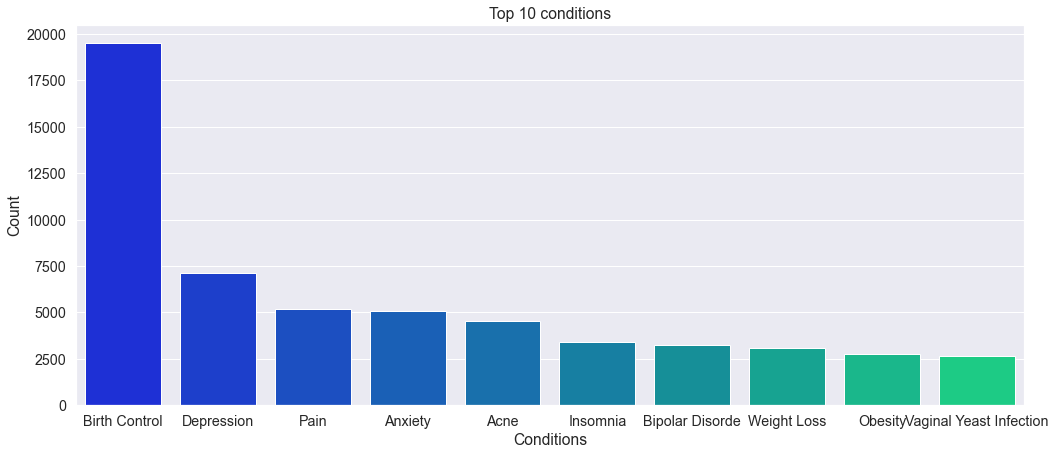

In [24]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

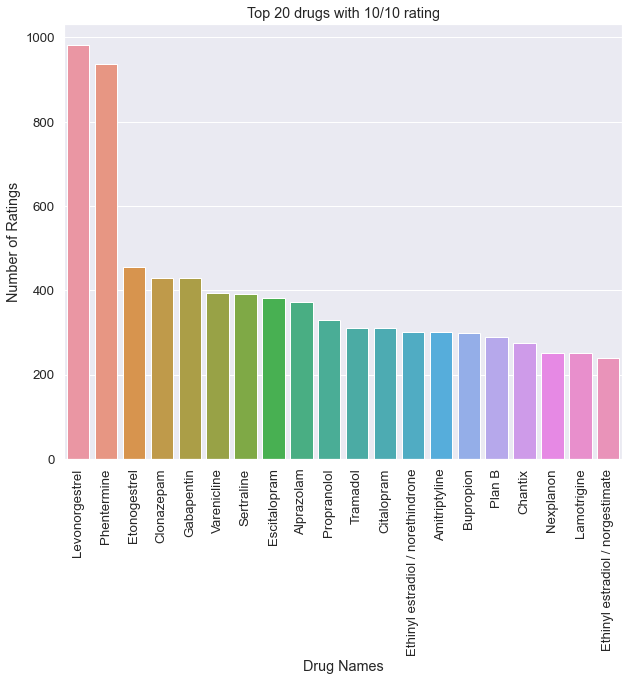

In [25]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

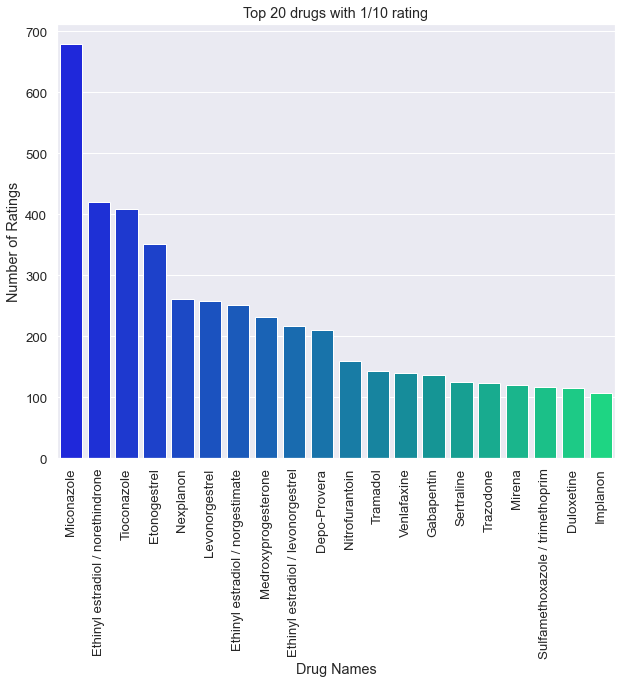

In [26]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

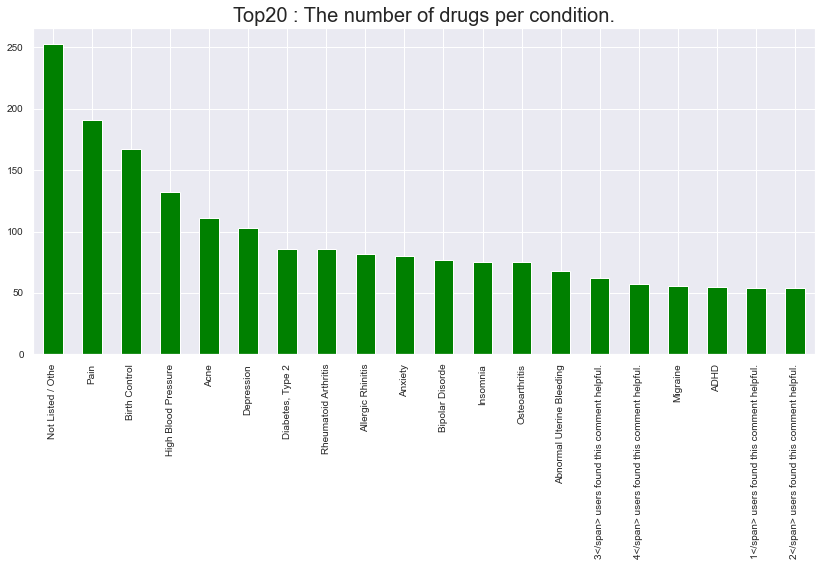

In [27]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [28]:
df.drugName.nunique()

3199

In [29]:
df.condition.nunique()

916

## Data Cleaning

### Clean 'condition' column

In [30]:
df["condition_clean"] = df.condition.apply(lambda x: "Unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [31]:
df.loc[df["condition_clean"] == "Unknown", "condition_clean"].count() 

1171

In [32]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [33]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [34]:
df["condition_clean"].nunique()

837

In [35]:
df["condition_clean"].isnull().sum()

1194

In [36]:
df["condition_clean"].fillna("Unknown", axis=0, inplace=True)
df

,drugName,condition,review,rating,date,usefulCount,length,condition_clean
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,17,Left Ventricular Dysfunction
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,141,ADHD
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,134,Birth Control
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,89,Birth Control
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,124,Opiate Dependence
...,...,...,...,...,...,...,...,...
130280,Methadone,Pain,"""Have been taking it for 6 years (120 milligra...",10,"August 2, 2011",16,12,Pain
130281,Clomipramine,Panic Disorde,"""I&#039;ve been on clomipramine 15 years now a...",10,"February 19, 2013",28,49,Panic Disorde
130282,Levetiracetam,Epilepsy,"""I now suffer from excessive tiredness and lac...",8,"July 21, 2016",5,20,Epilepsy
130283,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,"September 13, 2014",43,97,"Breast Cancer, Prevention"


In [37]:
df["condition_clean"].isnull().sum()

0

### Clean reviews (inplace)

In [38]:
df.drop(["date", "condition"], axis=1, inplace=True)

In [39]:
df["condition_clean"].nunique()
df[df["condition_clean"] == "unknown"]

,drugName,review,rating,usefulCount,length,condition_clean


In [40]:
df["review"] = df.review.str.replace("&#039;", "")
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""It has no side effect, I take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""My son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,"""I used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,"""This is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...
130280,Methadone,"""Have been taking it for 6 years (120 milligra...",10,16,12,Pain
130281,Clomipramine,"""Ive been on clomipramine 15 years now and bas...",10,28,49,Panic Disorde
130282,Levetiracetam,"""I now suffer from excessive tiredness and lac...",8,5,20,Epilepsy
130283,Tamoxifen,"""I have taken Tamoxifen for 5 years. Side effe...",10,43,97,"Breast Cancer, Prevention"


In [41]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [42]:
df

,drugName,review,rating,usefulCount,length,condition_clean
0,Valsartan,"""it has no side effect, i take it in combinati...",9,27,17,Left Ventricular Dysfunction
1,Guanfacine,"""my son is halfway through his fourth week of ...",8,192,141,ADHD
2,Lybrel,"""i used to take another oral contraceptive, wh...",5,17,134,Birth Control
3,Ortho Evra,"""this is my first time using any form of birth...",8,10,89,Birth Control
4,Buprenorphine / naloxone,"""suboxone has completely turned my life around...",9,37,124,Opiate Dependence
...,...,...,...,...,...,...
130280,Methadone,"""have been taking it for 6 years (120 milligra...",10,16,12,Pain
130281,Clomipramine,"""ive been on clomipramine 15 years now and bas...",10,28,49,Panic Disorde
130282,Levetiracetam,"""i now suffer from excessive tiredness and lac...",8,5,20,Epilepsy
130283,Tamoxifen,"""i have taken tamoxifen for 5 years. side effe...",10,43,97,"Breast Cancer, Prevention"


In [43]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,9
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,8
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,5
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,9
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,10
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,10
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,8
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,10


In [45]:
# Exporting clean dataset with rating 1-10
df_clean.drop(["review"], axis=1).to_excel("data/df_no_dups_totableau.xlsx")

### Feature engineering: 'rating'

In [46]:
df = df_clean
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,9
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,8
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,5
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,8
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,9
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,10
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,10
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,8
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,10


In [47]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

,drugName,condition_clean,review,usefulCount,length,rating
0,Valsartan,Left Ventricular Dysfunction,"""it has no side effect, i take it in combinati...",27,17,1
1,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",192,141,1
2,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",17,134,0
3,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",10,89,1
4,Buprenorphine / naloxone,Opiate Dependence,"""suboxone has completely turned my life around...",37,124,1
...,...,...,...,...,...,...
130280,Methadone,Pain,"""have been taking it for 6 years (120 milligra...",16,12,1
130281,Clomipramine,Panic Disorde,"""ive been on clomipramine 15 years now and bas...",28,49,1
130282,Levetiracetam,Epilepsy,"""i now suffer from excessive tiredness and lac...",5,20,1
130283,Tamoxifen,"Breast Cancer, Prevention","""i have taken tamoxifen for 5 years. side effe...",43,97,1


In [48]:
df['rating'].value_counts()

1    86434
0    43851
Name: rating, dtype: int64

## Creating the Corpus

In [49]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [50]:
len(corpus)

130285

In [51]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [53]:
len(corpus)

753513

### Cleaning corpus

In [54]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [55]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [191]:
# Tokenizing the corpus

In [56]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [57]:
len(list(wordfreq.keys()))

49773

In [58]:
wordfreq

{'it': 229415,
 'has': 38771,
 'no': 47360,
 'side': 42947,
 'effect': 8976,
 'i': 599027,
 'take': 36678,
 'in': 102644,
 'combination': 1357,
 'of': 138723,
 'bystolic': 176,
 'mg': 40053,
 'and': 347025,
 'fish': 135,
 'oil': 571,
 'my': 232957,
 'son': 1746,
 'is': 90229,
 'halfway': 143,
 'through': 7713,
 'his': 2496,
 'fourth': 481,
 'week': 22548,
 'intuniv': 141,
 'we': 5803,
 'became': 3483,
 'concerned': 751,
 'when': 29478,
 'he': 10939,
 'began': 4084,
 'this': 110705,
 'last': 12762,
 'started': 34109,
 'taking': 42381,
 'the': 326456,
 'highest': 283,
 'dose': 13028,
 'will': 21642,
 'be': 32380,
 'on': 108769,
 'for': 162154,
 'two': 17073,
 'days': 32834,
 'could': 12010,
 'hardly': 1075,
 'get': 32924,
 'out': 30585,
 'bed': 5269,
 'was': 140961,
 'very': 31625,
 'cranky': 133,
 'slept': 1583,
 'nearly': 1916,
 'hours': 13517,
 'a': 233272,
 'drive': 5193,
 'home': 2647,
 'from': 31203,
 'school': 2398,
 'vacation': 225,
 'unusual': 344,
 'him': 2372,
 'called': 1947,

### Reducing the corpus

#### Stopwords

In [59]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [60]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [61]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [62]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering'),
 (6115, 'thing

In [63]:
# Keeping 30 most preq words

corpus.sort(reverse = True)
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

In [64]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /home/sabeiro/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

#### LIST 1 [FULL]

In [65]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

Index(['side', 'taking', 'pain', 'year', 'take', 'effect', 'first', 'started',
       'like', 'month', 'get', 'day', 'time', 'feel', 'would', 'back', 'one',
       'week', 'pill', 'medication', 'took', 'also', 'doctor', 'weight', 'got',
       'life', 'anxiety', 'dont'],
      dtype='object')

In [66]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [67]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'pain': 0,
  'year': 0,
  'take': 1,
  'effect': 1,
  'first': 0,
  'started': 0,
  'like': 0,
  'month': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 0,
  'pill': 0,
  'medication': 0,
  'took': 0,
  'also': 0,
  'doctor': 0,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0},
 {'side': 0,
  'taking': 1,
  'pain': 0,
  'year': 0,
  'take': 0,
  'effect': 0,
  'first': 0,
  'started': 1,
  'like': 0,
  'month': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 2,
  'pill': 0,
  'medication': 1,
  'took': 0,
  'also': 0,
  'doctor': 1,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0}]

In [68]:
reviews = pd.DataFrame(my_list)

In [69]:
reviews

,side,taking,pain,year,take,effect,first,started,like,month,...,pill,medication,took,also,doctor,weight,got,life,anxiety,dont
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,3,1,0,0,1,2,1,1,0,0,...,2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,3,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130280,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130281,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
130282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130283,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [70]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

,side,taking,pain,year,take,effect,first,started,like,month,...,medication,took,also,doctor,weight,got,life,anxiety,dont,rating
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,3,1,0,0,1,2,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,3,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130280,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130281,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
130282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130283,1,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


#### LIST 3: stopwords incl. negation

In [71]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
new_stop_words = stop_words.difference(exclude_words)

In [72]:
new_stop_words = list(new_stop_words)

In [73]:
new_stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
new_stop_words

['mustn',
 'shan',
 'shouldn',
 'did',
 'those',
 'hasn',
 'themselves',
 'an',
 'doing',
 's',
 'my',
 'it',
 'at',
 'd',
 'yourself',
 'if',
 'yours',
 'you',
 'ma',
 't',
 'against',
 'now',
 'is',
 'the',
 'aren',
 'ourselves',
 'i',
 'there',
 'should',
 'or',
 'by',
 'who',
 'down',
 'so',
 'm',
 'she',
 'before',
 'his',
 'and',
 'up',
 'o',
 'few',
 'once',
 'has',
 'their',
 'myself',
 'whom',
 'during',
 'in',
 'that',
 'because',
 'other',
 'when',
 'wasn',
 'but',
 "you'll",
 'why',
 'after',
 'where',
 'out',
 'ain',
 'her',
 'between',
 'of',
 'herself',
 'from',
 'its',
 'have',
 'we',
 'yourselves',
 'was',
 'into',
 'are',
 'for',
 "it's",
 'with',
 'again',
 'only',
 'didn',
 'very',
 'needn',
 "should've",
 'some',
 'just',
 "won't",
 'these',
 'below',
 'having',
 'itself',
 'all',
 'this',
 'hadn',
 'mightn',
 "she's",
 'haven',
 'been',
 'a',
 're',
 'over',
 'further',
 'y',
 'couldn',
 'll',
 'here',
 "you'd",
 'off',
 'am',
 'our',
 'about',
 'him',
 'above',
 

In [74]:
for i in range(len(new_stop_words)):
    new_stop_words[i] = re.sub(r"\s*'\s*\w*","",new_stop_words[i])
new_stop_words

['mustn',
 'shan',
 'shouldn',
 'did',
 'those',
 'hasn',
 'themselves',
 'an',
 'doing',
 's',
 'my',
 'it',
 'at',
 'd',
 'yourself',
 'if',
 'yours',
 'you',
 'ma',
 't',
 'against',
 'now',
 'is',
 'the',
 'aren',
 'ourselves',
 'i',
 'there',
 'should',
 'or',
 'by',
 'who',
 'down',
 'so',
 'm',
 'she',
 'before',
 'his',
 'and',
 'up',
 'o',
 'few',
 'once',
 'has',
 'their',
 'myself',
 'whom',
 'during',
 'in',
 'that',
 'because',
 'other',
 'when',
 'wasn',
 'but',
 'you',
 'why',
 'after',
 'where',
 'out',
 'ain',
 'her',
 'between',
 'of',
 'herself',
 'from',
 'its',
 'have',
 'we',
 'yourselves',
 'was',
 'into',
 'are',
 'for',
 'it',
 'with',
 'again',
 'only',
 'didn',
 'very',
 'needn',
 'should',
 'some',
 'just',
 'won',
 'these',
 'below',
 'having',
 'itself',
 'all',
 'this',
 'hadn',
 'mightn',
 'she',
 'haven',
 'been',
 'a',
 're',
 'over',
 'further',
 'y',
 'couldn',
 'll',
 'here',
 'you',
 'off',
 'am',
 'our',
 'about',
 'him',
 'above',
 'doesn',
 'tha

In [75]:
corpus4 = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in new_stop_words]
corpus4

[(47360, 'no'),
 (42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering')

In [76]:
corpus4.sort(reverse = True)
corpus_freq4 = [(word[1],word[0]) for word in corpus4[:31]] 
corpus_freq4 = corpus_freq4[1:]
corpus_freq4

[('day', 48525),
 ('no', 47360),
 ('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369)]

In [77]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /home/sabeiro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [78]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
130280    1
130281    1
130282    1
130283    1
130284    1
Name: rating, Length: 130285, dtype: int64

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [80]:
X_train
#y_train

,side,taking,pain,year,take,effect,first,started,like,month,...,pill,medication,took,also,doctor,weight,got,life,anxiety,dont
28970,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,2,0,1,0,0
100957,3,1,1,2,0,3,1,0,0,0,...,2,0,0,0,0,1,0,0,0,0
108596,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
5119,0,0,0,1,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
98525,0,3,0,1,0,0,0,0,2,3,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,2,0,0,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
103694,0,0,0,0,1,0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0
860,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15795,0,0,0,0,0,0,0,0,1,3,...,0,1,0,0,0,0,0,3,0,0


In [81]:
y_test.value_counts()

rating
1         17232
0          8825
dtype: int64

In [82]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

### Making predictions with RF

In [83]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [84]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [85]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     35026
           1       0.90      0.98      0.94     69202

    accuracy                           0.92    104228
   macro avg       0.92      0.89      0.90    104228
weighted avg       0.92      0.92      0.91    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.13
              precision    recall  f1-score   support

           0       0.49      0.24      0.32      8825
           1       0.69      0.87      0.77     17232

    accuracy                           0.66     26057
   macro avg       0.59      0.55      0.54     26057
weighted avg       0.62      0.66      0.62     26057



#### Tuning the hyper paramters with gridsearch

In [222]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [223]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
grid_search.fit(X_train,y_train)

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

In [ ]:
grid_search.best_params_

In [ ]:
## Rerunning model

In [ ]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=50, min_samples_leaf =1 ,random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

#### Running the Naive Bayes model

In [ ]:
y_train
X_train

In [ ]:
nb = CategoricalNB()
nb.fit(X_train, y_train['rating'])

(Not) Making predictions with NB

In [ ]:
y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb  = nb.predict(X_test)

Model performance

In [ ]:
model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

### SVC instead of NB

In [ ]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42, tol=1e-2, max_iter=5000)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [ ]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

In [ ]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [ ]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [ ]:
reviews_cleaned = df.copy()

In [ ]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [ ]:
reviews_cleaned.head()

In [ ]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [ ]:
reviews_cleaned.head()

### >>> Running the TF-IDF model 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [ ]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [ ]:
tidf.get_feature_names()

In [ ]:
len(tidf.get_feature_names())

In [ ]:
X_TF[:2,:5]

#### Train test split

In [ ]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_train)

#### Generating the model

In [ ]:
rf1 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf1.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf1.predict(X_TF_train)
y_TF_test_pred_rf  = rf1.predict(X_TF_test)

#### Model performance

In [ ]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                         precision_score(y_TF_train, y_TF_train_pred_rf),
                                         recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})

display(performance_df)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train,y_TF_train_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_train, y_TF_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test,y_TF_test_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_test,y_TF_test, values_format = 'd')
plt.show()

In [ ]:
ax = sns.barplot(x="Error_metric", y="Test", data=performance_df)

## LIST 1: POS tagging ins. of stopwords

### Applying tags and filtering POS

In [ ]:
nltk.help.upenn_tagset()

### Tokenizing

In [ ]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [ ]:
list_filtered = filter_review(str(corpus_pre_tok))

In [ ]:
len(list_filtered)

### Reducing the list

In [ ]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [ ]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

In [ ]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE

In [ ]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

In [ ]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

In [ ]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down 

### Re-running models with downsample

In [ ]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

In [ ]:
len(corpus2)

In [ ]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

In [ ]:
len(corpus2)

### Cleaning corpus

In [ ]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

In [ ]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

In [ ]:
# Tokenizing the corpus

In [ ]:
wordfreq2 = {}
for sentence in corpus2:
    words2 = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words2:
        if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
            wordfreq2[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq2[word] += 1 # We increase the corresponding counter

In [ ]:
len(list(wordfreq2.keys()))

In [ ]:
wordfreq2

### Reducing the corpus

#### POS tagging

In [ ]:
nltk.help.upenn_tagset()

#### Generating LIST 2 [down]

In [ ]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [ ]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [ ]:
len(list_filtered2)

In [ ]:
list_filtered2

In [ ]:
# Matching with frequencies

In [ ]:
wordfreq3 = {}
for word in list_filtered2:
    if ( word not in wordfreq3.keys() ): ## first time appearnce in the sentence
        wordfreq3[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq3[word] += 1 # We increase the corresponding counter

In [ ]:
len(list(wordfreq3.keys()))

In [ ]:
wordfreq3

In [ ]:
corpus3 = [(wordfreq3[key],key) for key in list(wordfreq3.keys()) if key not in stop_words]
corpus3

In [ ]:
corpus3.sort(reverse = True)
corpus_freq3 = [(word[1],word[0]) for word in corpus3[:31]] 
corpus_freq3 = corpus_freq3[1:]
corpus_freq3

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq3 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq3]
corpus_freq3

In [ ]:
cols2 = {word[0]: [] for word in corpus_freq3}
reviews2 = pd.DataFrame(cols2)

reviews2.columns

In [ ]:
cols2

In [ ]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Clean up the token
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [ ]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

In [ ]:
reviews2 = pd.DataFrame(my_list2)

In [ ]:
reviews2

In [ ]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

## Modeling (DOWNSAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## >>> Running the RanFor Model with BOW

In [ ]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [ ]:
X_train2
#y_train2

In [ ]:
y_test2.value_counts()

In [ ]:
rf2 = RandomForestClassifier()

rf2.fit(X_train2, y_train2['rating'])

### Making predictions with RF

In [ ]:
y_train_pred_rf2 = rf2.predict(X_train2)
y_test_pred_rf2  = rf2.predict(X_test2)

In [ ]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [ ]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

In [ ]:
# After balancing, overall score is lower, precision overall lower
# test + train set recall better for lower rating drugs [0] (less false positives)
# But more false negatives - good drugs [1] are predicted as bad more often

#### Tuning the hyper paramters with gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

grid_search.fit(X_train2,y_train2)

In [ ]:
grid_search.best_params_

In [ ]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, random_state=42)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

In [ ]:
# What does that mean?

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

## TF_IDF DOWNSAMPLE

### >>> With uni + bigrams

In [ ]:
df_down

In [ ]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [ ]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [ ]:
y_TF2

In [ ]:
tidf.get_feature_names()

In [ ]:
len(tidf.get_feature_names())

In [ ]:
X_TF2[:2,:5]

#### Train test split

In [ ]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_train2)

#### Generating the model

In [ ]:
rf3 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf3.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf3.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf3.predict(X_TF_test2)

#### Model performance

In [ ]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

In [ ]:
# best results obtained with uni- AND bi-grams, max_depth 200

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df_best = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                                         precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})

display(performance_df_best)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train2,y_TF_train_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_train2, y_TF_train2, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test2,y_TF_test_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_test2,y_TF_test2, values_format = 'd')
plt.show()

### >>> With bigrams only

In [ ]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [ ]:
X_TF_down_bi = tidf.fit_transform(df_down['review'])
y_TF_down_bi = df_down['rating']

#### Train test split

In [ ]:
X_TF_down_bi_train, X_TF_down_bi_test, y_TF_down_bi_train, y_TF_down_bi_test = train_test_split(X_TF_down_bi, y_TF_down_bi, test_size=0.20, random_state=42)

In [ ]:
type(X_TF_down_bi_train)

#### Generating the model

In [ ]:
rf4 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_down_bi_train = y_TF_down_bi_train.astype('int')
y_TF_down_bi_test  = y_TF_down_bi_test.astype('int')

rf4.fit(X_TF_down_bi_train, y_TF_down_bi_train)

y_TF_down_bi_train_pred_rf = rf4.predict(X_TF_down_bi_train)
y_TF_down_bi_test_pred_rf  = rf4.predict(X_TF_down_bi_test)

#### Model performance

In [ ]:
model_performance_class(y_TF_down_bi_train, y_TF_down_bi_train_pred_rf, y_TF_down_bi_test, 
                        y_TF_down_bi_test_pred_rf)

#### Tuning the hyper paramters with gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [ ]:
grid_search.fit(X_TF_train2,y_TF_train2)

In [ ]:
grid_search.best_params_

In [ ]:
#pd.DataFrame(grid_search.cv_results_)

In [ ]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

In [ ]:
metrics.RocCurveDisplay

In [ ]:
metrics.RocCurveDisplay.from_estimator

In [ ]:
# 1 - BOW, down
disp = plot_roc_curve(rf2, X_test2, y_test2, name="BOW, balanced")
plt.gcf().set_size_inches(12,6)
#2 - TF-IDF down bi grams
plot_roc_curve(rf4, X_TF_down_bi_test, y_TF_down_bi_test, name="TF-IDF, balanced, bigrams", ax=disp.ax_);

#3 - TF-IDF down uni/bi grams
plot_roc_curve(rf3, X_TF_test2, y_TF_test2, name="TF-IDF, balanced, uni+bigrams", ax=disp.ax_);

#4 - TF-IDF full uni/bi grams
plot_roc_curve(rf1, X_TF_test, y_TF_test, name="TF-IDF, imbalanced, uni+bigrams", ax=disp.ax_);

In [ ]:
# Plot recall (chose green option as recall for cat 1 is better)

In [ ]:
performance_df1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                #         precision_score(y_TF_train, y_TF_train_pred_rf),
                                 #        recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})
performance_df_best1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                               #          precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                #         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})


In [ ]:
performance_df1

In [ ]:
performance_df_best1